# Multivariate linear regression

Multivariate linear regression on simulated data

Our model is:

$$\mathbf{Y} = \mathbf{X}\mathbf{B} + \mathbf{E}$$

where $\mathbf{Y}$ (dependent variables we want to predict, outcomes) and $\mathbf{E}$ (gaussian error $\mathcal{N}(0,\Sigma)$) are $(N_{obs}, M)$ matrices, $\mathbf{X}$ (dependent variable/predictors/explanatory variables) is a $(N_{obs}, N)$ matrix and $\mathbf{B}$ (parameters we will try to infer) is a $(N, M)$ matrix.

# PyStan code

In [1]:
import pystan
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("multivariate_data.csv").set_index(["category","number"])
X = data.loc["x"].values.T
Y = data.loc["y"].values.T
N_obs, N = X.shape
M = Y.shape[1]

In [3]:
multivariate_lr_code = """
data {
    int<lower=1> M;     // num of outcomes
    int<lower=1> N;     // num of explanatory variables
    int<lower=0> N_obs; // num of obs

    vector[N] x[N_obs];     
    vector[M] y[N_obs];     
}
parameters {
    matrix[N, M] B;     
    cov_matrix[M] Sigma;
}

transformed parameters {
    vector[M] mu[N_obs];
  
    for (n in 1:N_obs){
        mu[n] = transpose(B) * x[n];
    }
}

model {

    y ~ multi_normal(mu, Sigma);
    
}

generated quantities {
    vector[N_obs] log_lik;
    vector[M] y_hat[N_obs];
    
    for (n in 1:N_obs){
        log_lik[n] = multi_normal_lpdf(y[n] | mu[n], Sigma);
    }
    
    y_hat = multi_normal_rng(mu, Sigma);
}
"""

In [4]:
multivariate_lr_dat = {
    'N': N,
    'M': M,
    'N_obs': N_obs,
    'y': Y,
    'x': X,
}

sm = pystan.StanModel(model_code=multivariate_lr_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13230a6f3c60d41c088298b1584d36ac NOW.


In [5]:
fit = sm.sampling(data=multivariate_lr_dat, iter=3000, chains=8, control={"max_treedepth":15, "adapt_delta":.85})

In [6]:
dims = {"y":["N_obs", "M"], 
        "x":["N_obs","N"], 
        "B": ["N", "M"], 
        "Sigma": ["M1", "M2"], 
        "y_hat": ["N_obs", "M"], 
        "log_lik":["N_obs"],
        "mu":["N_obs", "M"]}
coords = {"N_obs":range(N_obs),"N":range(N), "M": range(M), "M1": range(M), "M2": range(M)}
idata = az.from_pystan(
    posterior=fit,
    observed_data=['y', 'x'],
    posterior_predictive="y_hat",
    log_likelihood="log_lik",
    coords=coords,
    dims=dims
)

In [7]:
az.summary(idata, var_names=["Sigma"])

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Sigma[0,0]",59.367,197.853,4.820,3.409,2.903,155.042,1685.0,1685.0,1645.0,1906.0,1.00
"Sigma[0,1]",12.740,80.225,1.301,0.920,-24.845,69.496,3804.0,3804.0,3947.0,2471.0,1.00
"Sigma[0,2]",-42.756,170.648,3.874,2.740,-135.662,18.545,1941.0,1941.0,2205.0,1944.0,1.00
"Sigma[0,3]",19.771,76.686,1.670,1.181,-17.245,73.396,2108.0,2108.0,3135.0,2093.0,1.00
"Sigma[0,4]",23.348,90.338,2.080,1.471,-19.312,90.577,1887.0,1887.0,2704.0,2069.0,1.00
"Sigma[1,0]",12.740,80.225,1.301,0.920,-24.845,69.496,3804.0,3804.0,3947.0,2471.0,1.00
"Sigma[1,1]",19.769,88.374,1.790,1.266,0.899,50.742,2439.0,2439.0,1796.0,2072.0,1.01
"Sigma[1,2]",0.044,79.918,1.262,0.893,-51.648,41.858,4009.0,4009.0,4356.0,2797.0,1.00
"Sigma[1,3]",-3.666,42.342,0.655,0.463,-32.565,22.272,4177.0,4177.0,4204.0,3027.0,1.00
"Sigma[1,4]",3.354,44.361,0.589,0.452,-26.007,39.182,5668.0,4818.0,4420.0,2630.0,1.00


In [8]:
idata.to_netcdf("multivariate_LR_pystan.nc")

'multivariate_LR_pystan.nc'

## Compare results to real parameters

In [9]:
data = pd.read_csv("multivariate_real_params.csv").set_index(["category","number"])
B = data.loc["b"].values
Sigma = data.loc["sigma"].values  

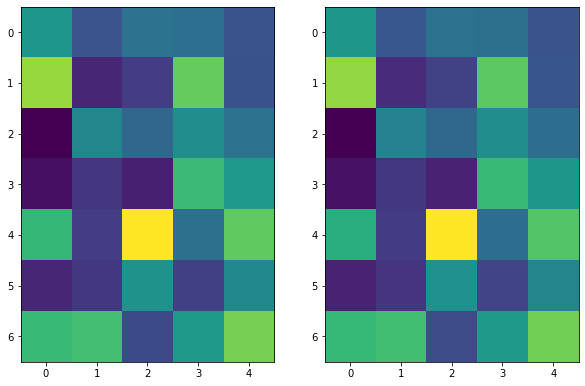

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,7))
axes[0].imshow(B)
B_hat = np.median(idata.posterior.B.values.reshape((-1,N,M)),axis=0)
axes[1].imshow(B_hat)

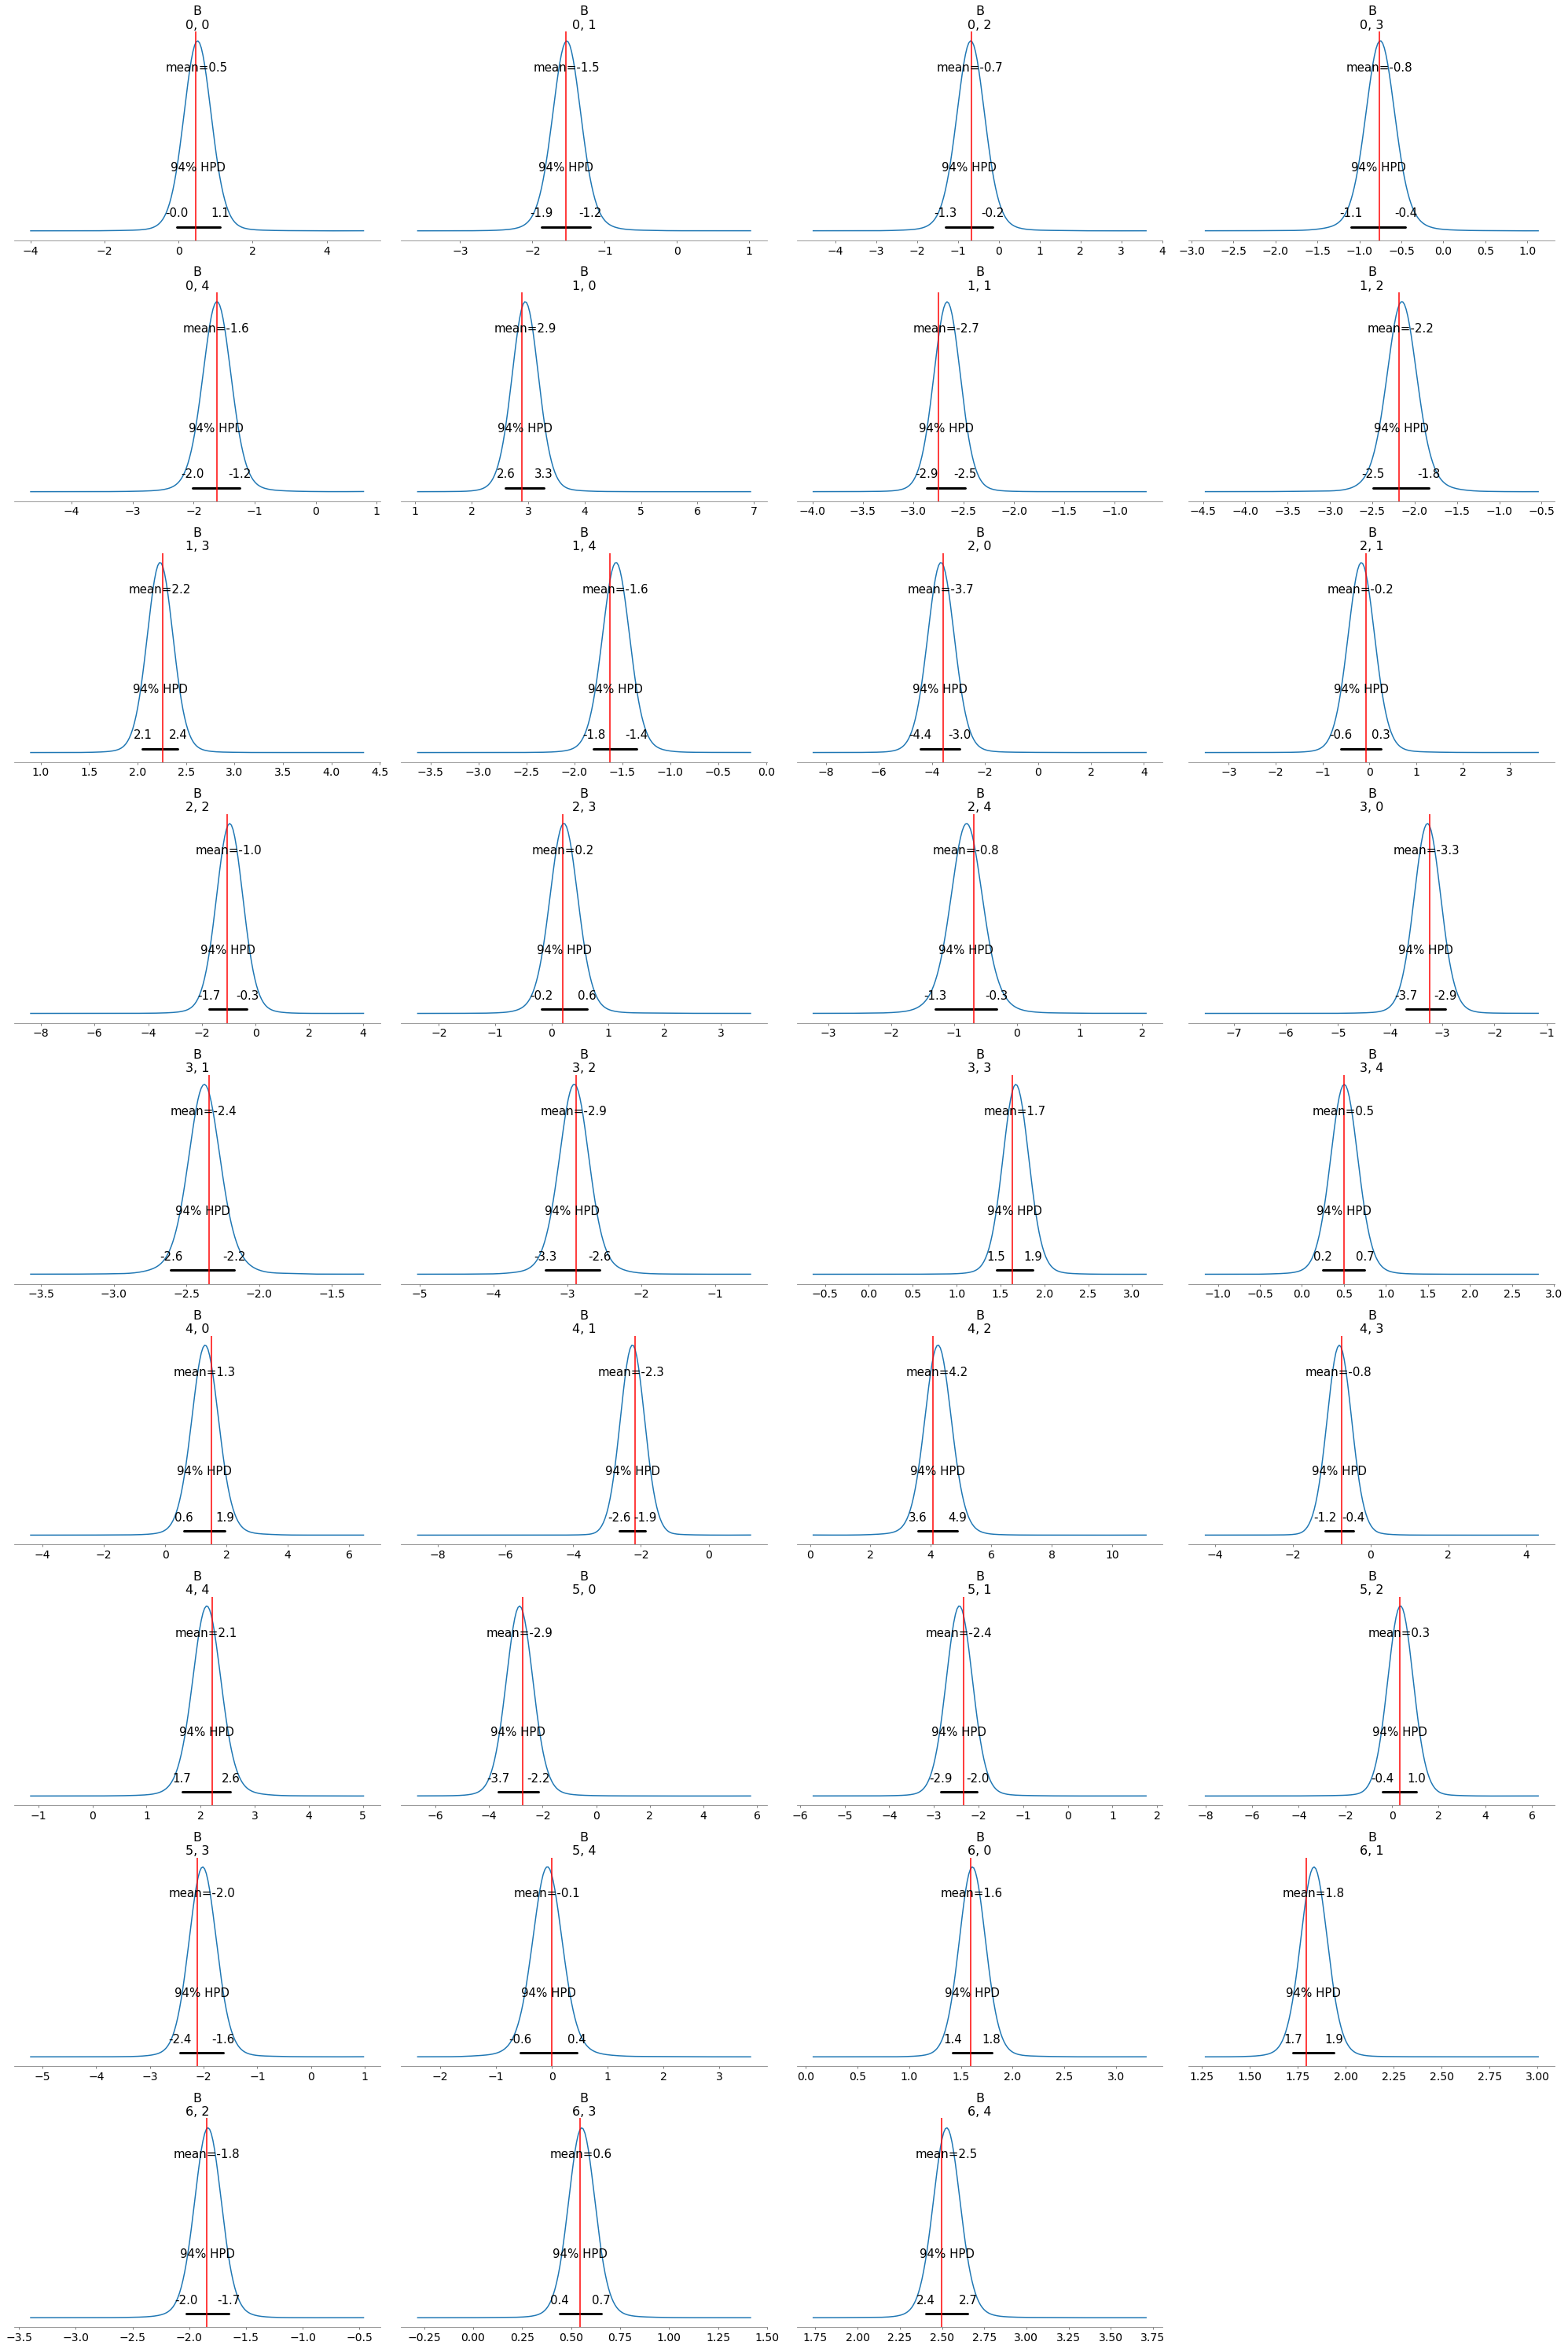

In [11]:
axes = az.plot_posterior(idata, var_names=["B"]);
for ax, truth in zip(axes.flatten(),B.flatten()):
    ax.axvline(truth,color="r")

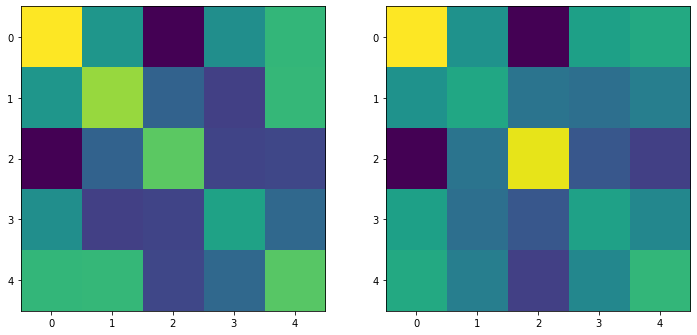

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,7))
axes[0].imshow(Sigma)
Sigma_hat = np.median(idata.posterior.Sigma.values.reshape((-1,M,M)),axis=0)
axes[1].imshow(Sigma_hat)

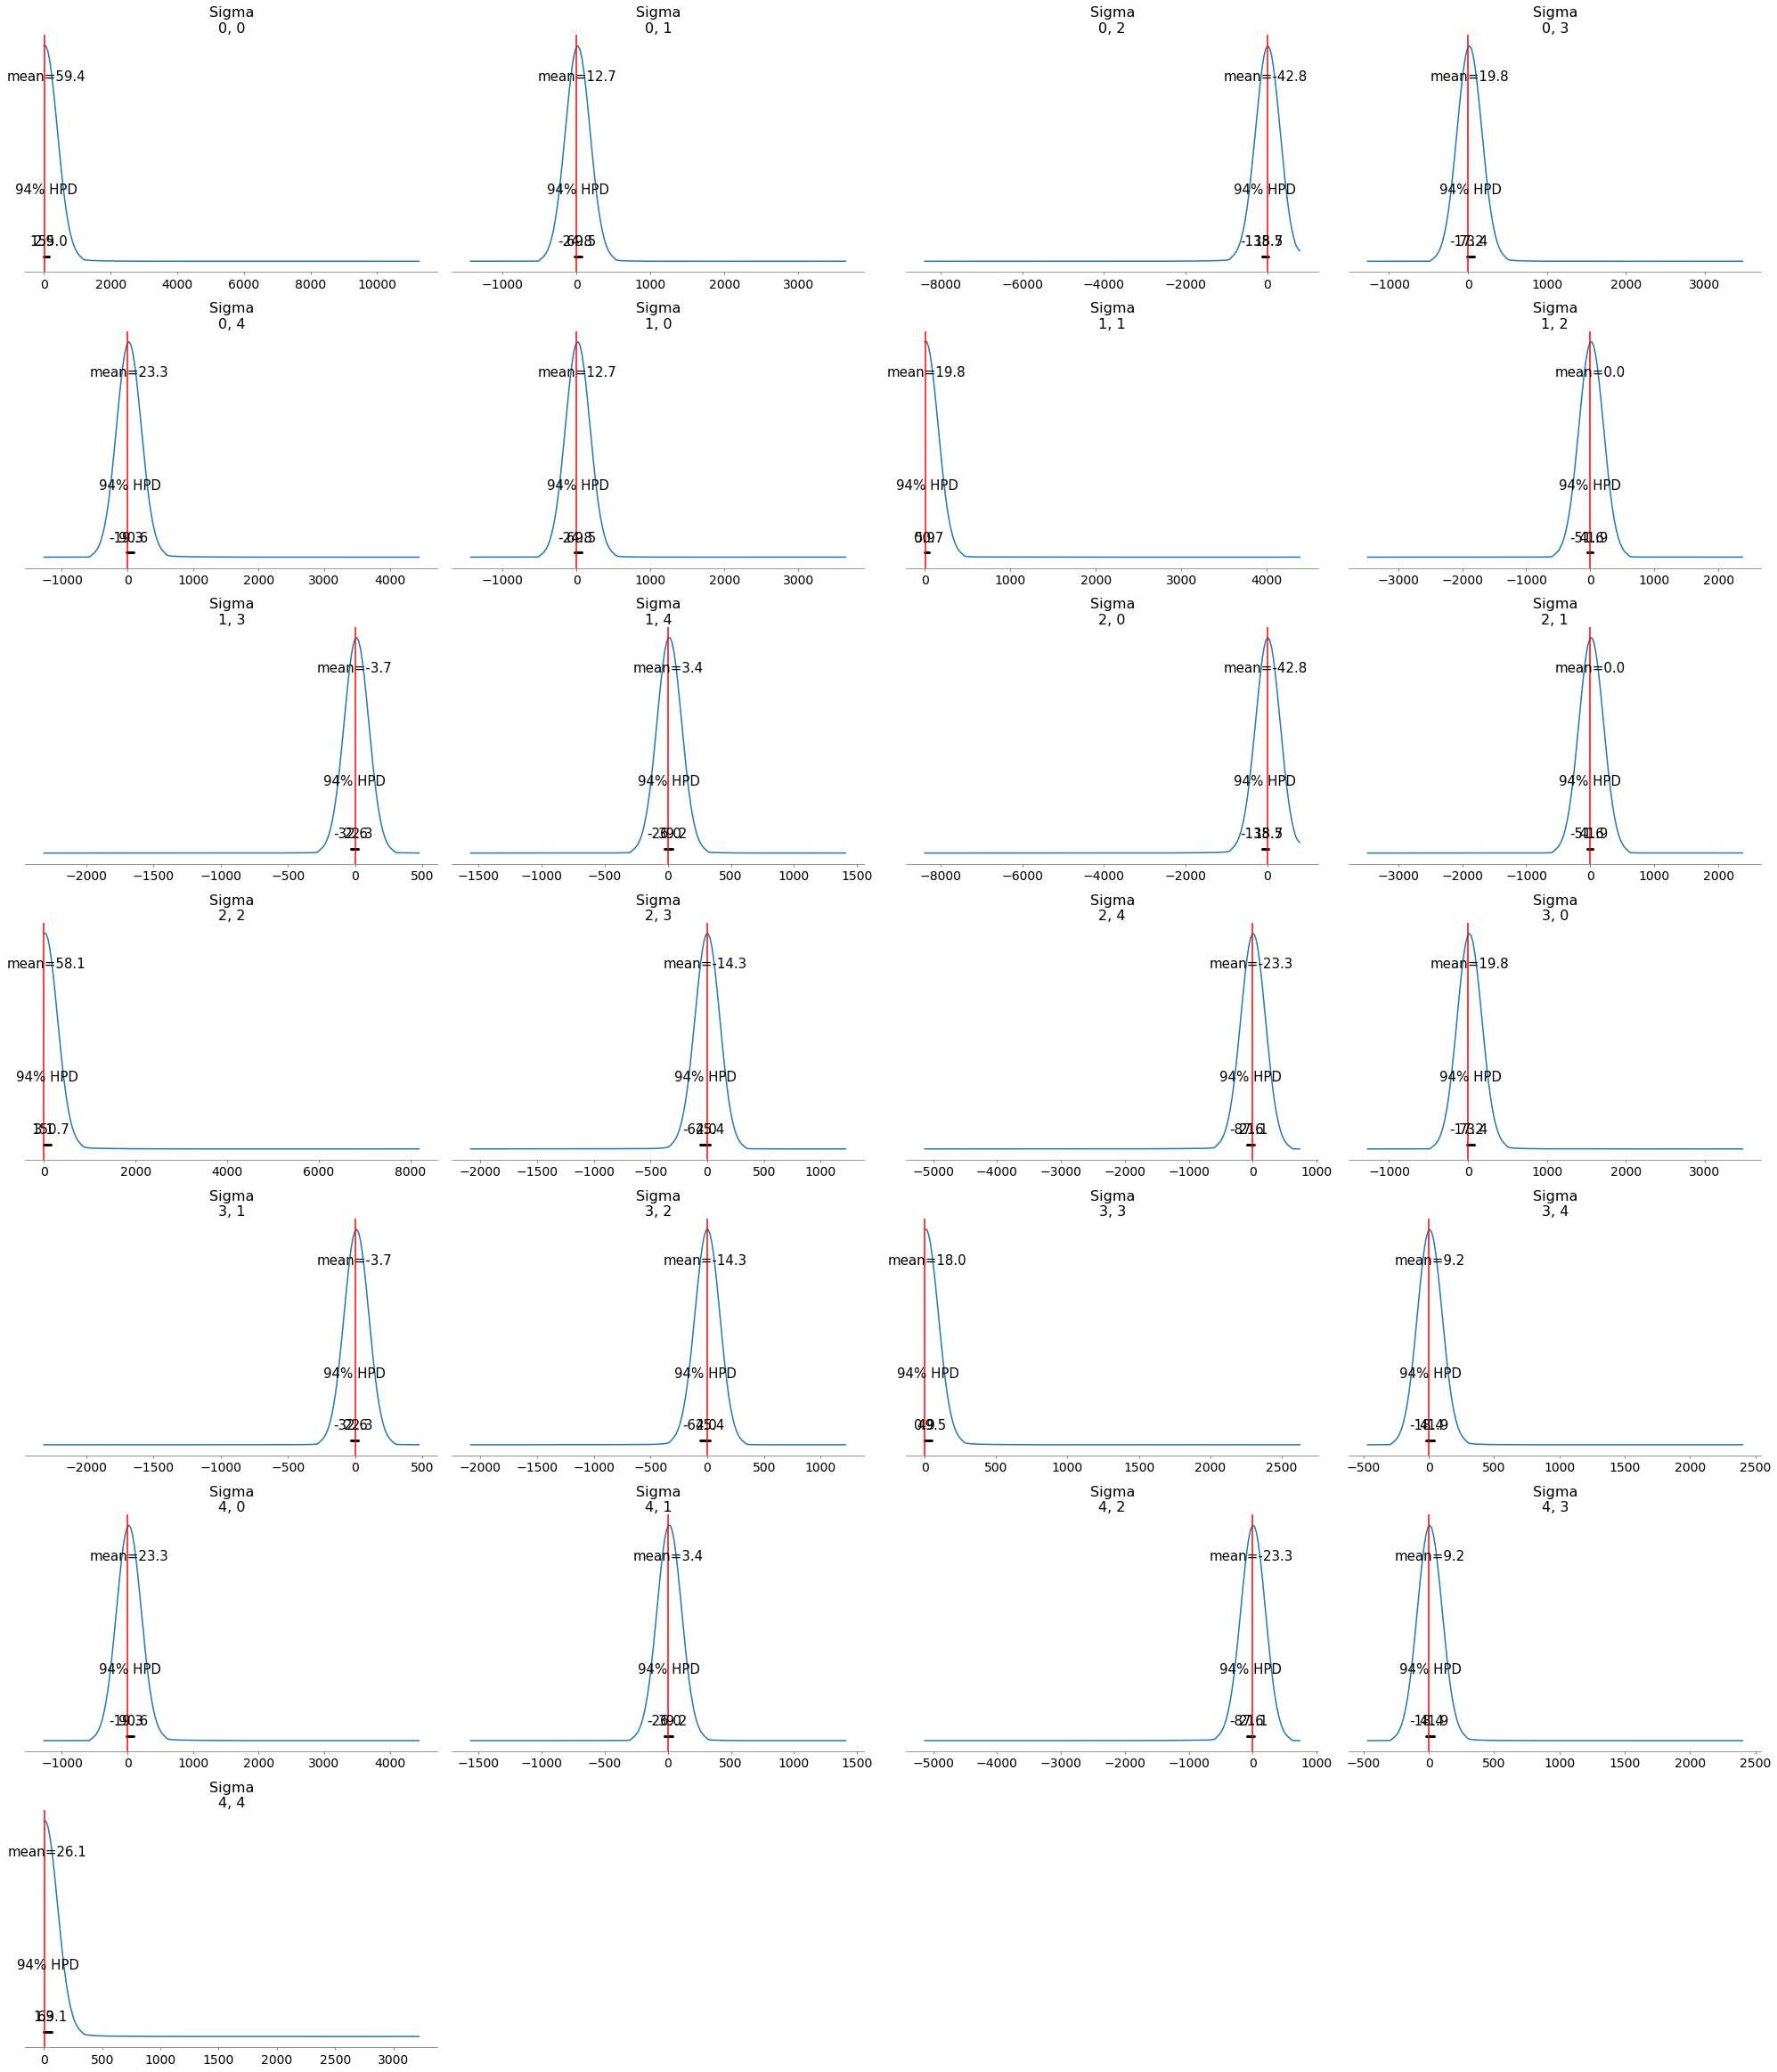

In [13]:
axes = az.plot_posterior(idata, var_names=["Sigma"]);
for ax, truth in zip(axes.flatten(),Sigma.flatten()):
    ax.axvline(truth,color="r")